In [1]:
import astropy.io.fits as fits
from astropy.wcs import WCS
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
from scipy.optimize import curve_fit
from healpy.newvisufunc import projview


import local_reversal
from reproject import reproject_from_healpix, reproject_to_healpix

from healpy.newvisufunc import projview

from dustmaps.edenhofer2023 import Edenhofer2023Query
import astropy.units as units
from astropy.coordinates import SkyCoord


from astrohog2d import *
from statests import *

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from astropy.io import fits

from scipy import ndimage

# recenter M1

In [16]:
# open data
m = fits.getdata("M1hpx.fits")
fdcube = fits.getdata("fdcubeCLEANhpx.fits")
fdcube = np.load("fdcubeCLEANhpx_V2.npy")
fdvals = np.linspace(-1000, 1000, 2001)

# central coordinates of region
l0, b0 = 80, 30

# make header for desired projection
header = fits.getheader("M1.fits")

header["CRVAL1"] = l0
header["CRVAL2"] = b0

# reproject from healpix into 2d array centred at (l0, b0)
cs = 'G'
DRM1, footprint = reproject_from_healpix((m, cs), header, nested=False)


In [23]:
long = np.linspace(l0 + 180, l0 - 180, 720)
lat = np.linspace(b0 - 90, b0 + 90, 360)

# recenter dust

In [22]:
# load previously saved dust cube in DRAGONS resolution
dustcube = np.load("dustcube128.npy")

# reproject into array centred at (l0, b0)
dustcube2d1 = np.zeros([1201, DRM1.shape[0], DRM1.shape[1]])

for n in range(1201):
    cs = 'G'
    temp, footprint = reproject_from_healpix((dustcube[n], cs), header, nested=False)
    dustcube2d1[n] = temp

# Astrohog positive region

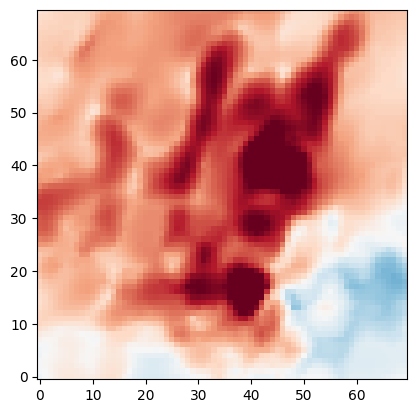

In [28]:
lp, bp = 45, 35

longind = np.abs(long - lp).argmin()
latind = np.abs(lat - bp).argmin()

width = 35

plt.imshow(DRM1[latind - width: latind + width, longind - width: longind+width], origin = "lower",  cmap = "RdBu_r", vmin = -30, vmax= 30)

In [29]:
image1 = np.abs(DRM1[latind - width: latind + width, longind - width: longind+width])

# derivative kernel in pixels
ksz=3

mask1 = np.ones(image1.shape)
mask2 = mask1.copy()

# calculate astrohog statistics for each dust distance
distvals = []
p_vals = []
rvl_vals = []
v_vals = []

for dist in range(70, 1000):

    image2 = np.log10(dustcube2d1[dist][latind - width: latind + width, longind - width: longind+width])

    circstats, corrframe, simage1, simage2 = HOGcorr_imaLITE(image1, image2, ksz=ksz, mask1=mask1, mask2=mask2)
    
    distvals.append(dist)
    v_vals.append(circstats['V'])
    rvl_vals.append(circstats['RVL'])
    p_vals.append(circstats['pearsonr'])

v_vals = np.array(v_vals)
rvl_vals = np.array(rvl_vals)
p_vals = np.array(p_vals)
distvals = np.array(distvals)

In [35]:
distvals[p_vals.argmax()], distvals[v_vals.argmax()]

(490, 492)

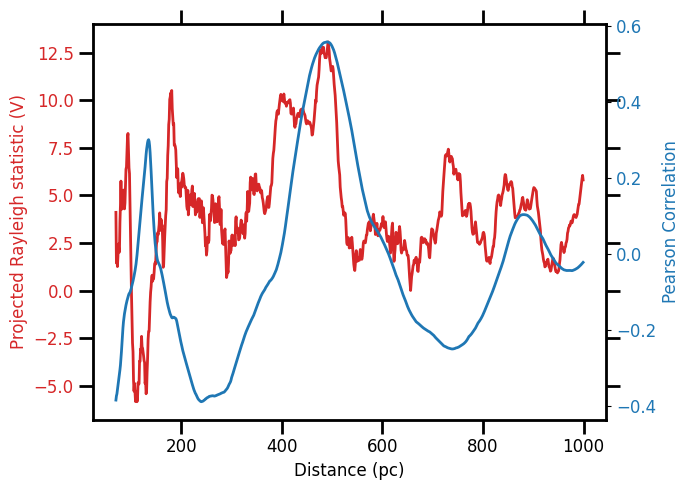

In [34]:
# plot the results

fig, ax1 = plt.subplots(figsize = (7,5))

fs = 12

color = 'tab:red'
ax1.set_xlabel('Distance (pc)', fontsize = fs)
ax1.set_ylabel('Projected Rayleigh statistic (V)', color=color, fontsize = fs)
ax1.plot(distvals, v_vals, color=color, linewidth = 2)
ax1.tick_params(axis='y', labelcolor=color, labelsize = fs)
ax1.tick_params(axis='x', labelcolor="k", labelsize = fs)

ax2 = ax1.twinx()  # instantiate a second Axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Pearson Correlation', color=color, fontsize = fs)  # we already handled the x-label with ax1
ax2.plot(distvals, p_vals, color=color, linewidth = 2)
ax2.tick_params(axis='y', labelcolor=color, labelsize = fs)
ax2.tick_params(axis='x', labelcolor="k", labelsize = fs)

for spine in ax1.spines.values():
        spine.set_visible(True)
        spine.set_linewidth(2)

ax1.tick_params(axis='both', labelsize=fs, left=True, right=True, top=True, which='both', width=2, length=10)

fig.tight_layout()  



# Astrohog negative region 

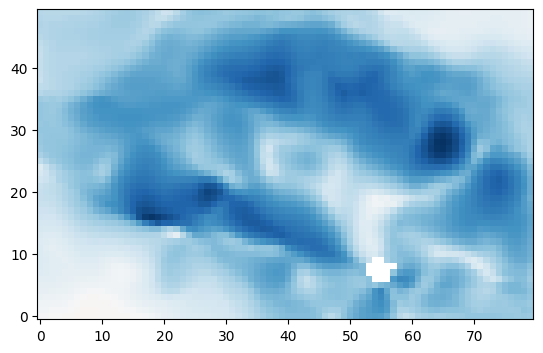

In [92]:
ln, bn = 125, 43

longind = np.abs(long - ln).argmin()
latind = np.abs(lat - bn).argmin()

xwidth = 40
ywidth = 25

plt.imshow(DRM1[latind - ywidth: latind + ywidth, longind - xwidth: longind+xwidth], origin = "lower",  cmap = "RdBu_r", vmin = -30, vmax= 30)


In [93]:
image1 = np.abs(DRM1[latind - ywidth: latind + ywidth, longind - xwidth: longind+xwidth])

# derivative kernel in pixels
ksz=3

mask1 = np.ones(image1.shape)
mask2 = mask1.copy()

# calculate astrohog statistics for each dust distance
distvals = []
p_vals = []
rvl_vals = []
v_vals = []

for dist in range(70, 1000):

    image2 = np.log10(dustcube2d1[dist][latind - ywidth: latind + ywidth, longind - xwidth: longind+xwidth])

    circstats, corrframe, simage1, simage2 = HOGcorr_imaLITE(image1, image2, ksz=ksz, mask1=mask1, mask2=mask2)
    
    distvals.append(dist)
    v_vals.append(circstats['V'])
    rvl_vals.append(circstats['RVL'])
    p_vals.append(circstats['pearsonr'])

v_vals = np.array(v_vals)
rvl_vals = np.array(rvl_vals)
p_vals = np.array(p_vals)
distvals = np.array(distvals)

In [94]:
distvals[p_vals.argmax()], distvals[v_vals.argmax()]

(398, 400)

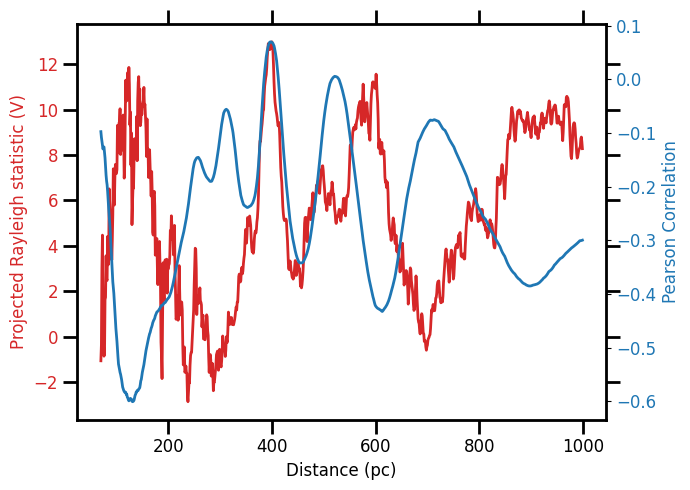

In [95]:
# plot the results

fig, ax1 = plt.subplots(figsize = (7,5))

fs = 12

color = 'tab:red'
ax1.set_xlabel('Distance (pc)', fontsize = fs)
ax1.set_ylabel('Projected Rayleigh statistic (V)', color=color, fontsize = fs)
ax1.plot(distvals, v_vals, color=color, linewidth = 2)
ax1.tick_params(axis='y', labelcolor=color, labelsize = fs)
ax1.tick_params(axis='x', labelcolor="k", labelsize = fs)

ax2 = ax1.twinx()  # instantiate a second Axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Pearson Correlation', color=color, fontsize = fs)  # we already handled the x-label with ax1
ax2.plot(distvals, p_vals, color=color, linewidth = 2)
ax2.tick_params(axis='y', labelcolor=color, labelsize = fs)
ax2.tick_params(axis='x', labelcolor="k", labelsize = fs)

for spine in ax1.spines.values():
        spine.set_visible(True)
        spine.set_linewidth(2)

ax1.tick_params(axis='both', labelsize=fs, left=True, right=True, top=True, which='both', width=2, length=10)

fig.tight_layout()  



# plot figure

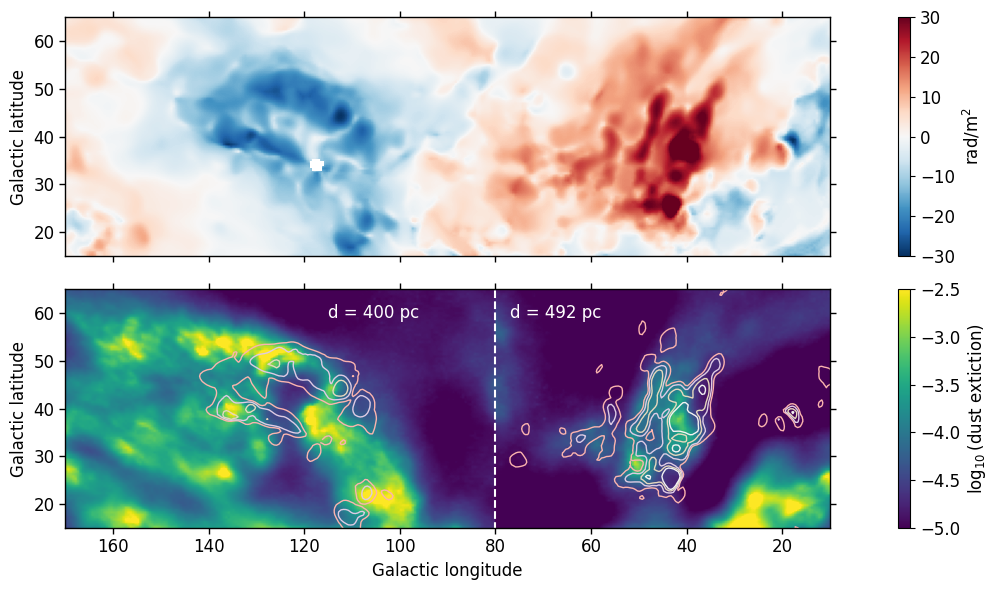

In [140]:
fig, ax = plt.subplots(2,1, figsize = (14, 6), sharex = True)

plt.sca(ax[0])

fs = 12

plt.imshow(DRM1, origin = "lower", extent = (l0+180, l0-180, b0-90, b0+90), cmap = "RdBu_r", vmin = -30, vmax= 30)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=fs)
cbar.set_label('rad/m$^2$', rotation=90, labelpad=20,  fontsize=fs)
cbar.ax.yaxis.label.set_verticalalignment('bottom')


plt.xlim(180, 10)
plt.ylim(15, 65)

plt.ylabel("Galactic latitude", fontsize = fs)
#plt.xlabel("Galactic longitude", fontsize = fs)

for spine in ax[0].spines.values():
    spine.set_visible(True)
    spine.set_linewidth(1)

ax[0].tick_params(axis='both', labelsize=fs, left=True, right=True,
                  top=True, which='both', width=1, length=4)

plt.sca(ax[1])

plt.imshow(np.log10(temp), origin = "lower", extent = (l0+180, l0-180, b0-90, b0+90),  vmin = -5, vmax = -2.5)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=fs)
cbar.set_label('$\log_{10}$(dust extiction)', rotation=90, labelpad=20,  fontsize=fs)
cbar.ax.yaxis.label.set_verticalalignment('bottom')

plt.contour(np.abs(DRM1),  origin = "lower", extent = (l0+180, l0-180, b0-90, b0+90), levels = [15, 20, 25, 30], cmap = "Pastel1", linewidths=1)


plt.xlim(170, 10)
plt.ylim(15, 65)

plt.ylabel("Galactic latitude", fontsize = fs)
plt.xlabel("Galactic longitude", fontsize = fs)

for spine in ax[1].spines.values():
    spine.set_visible(True)
    spine.set_linewidth(1)

ax[1].tick_params(axis='both', labelsize=fs, left=True, right=True,
                  top=True, which='both', width=1, length=4)

plt.plot(np.ones(10)*80, np.linspace(10, 65, 10), "w--")

plt.text(115, 59, "d = 400 pc", c = "white", fontsize = fs)
plt.text(77, 59, "d = 492 pc", c = "white", fontsize = fs)

plt.xticks([n for n in range(20, 171, 20)]);

plt.tight_layout()


plt.savefig("M1_regions.pdf", bbox_inches='tight')